Chargement des données depuis ../data/processed/creditcard_processed.csv
Création et ajustement d'un nouveau StandardScaler...
Chargement du modèle depuis ../agents/models/xgb_fraud_detector.pkl
Prédiction en cours...

Rapport de classification
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998    284315
           1     0.9103    0.8455    0.8767       492

    accuracy                         0.9996    284807
   macro avg     0.9550    0.9227    0.9383    284807
weighted avg     0.9996    0.9996    0.9996    284807


Métriques supplémentaires
ROC AUC: 0.9893
PR AUC: 0.9204

Matrice de confusion


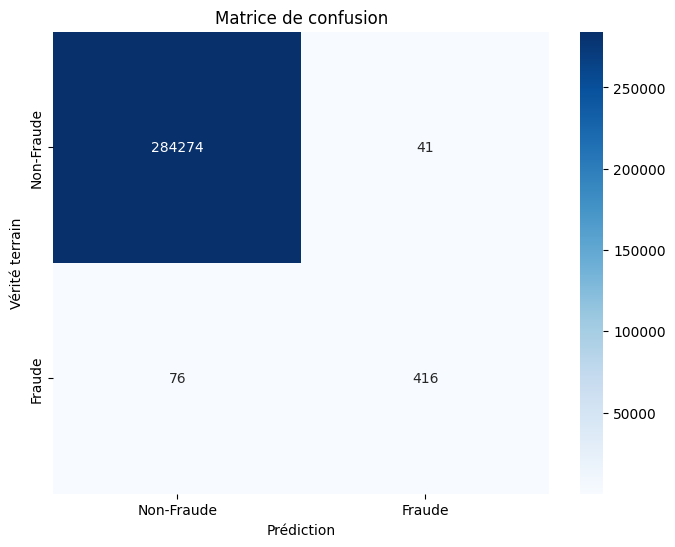

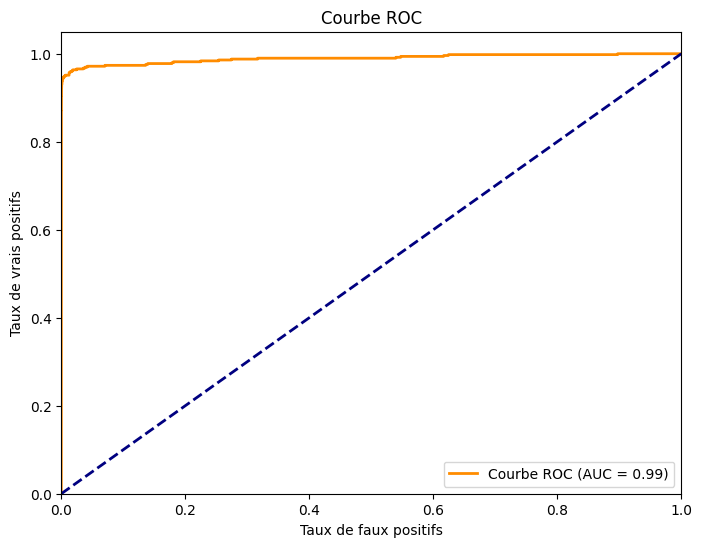

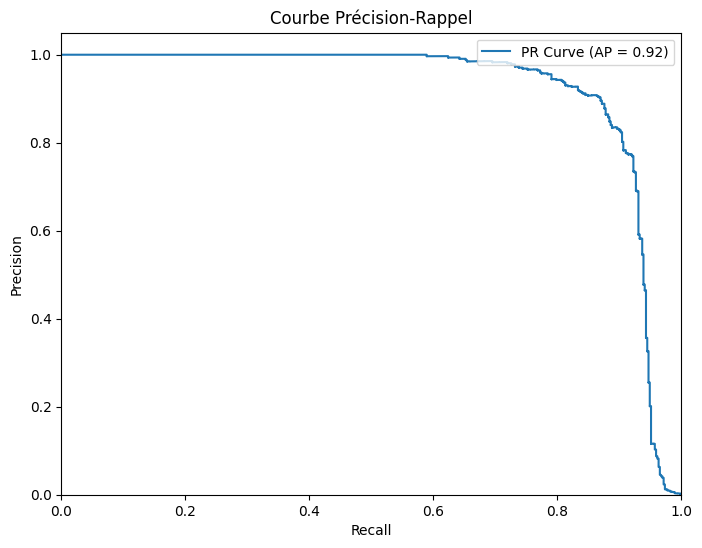

In [2]:
# ================================
# 03_xgb_best_model.ipynb (FIXED)
# ================================

import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    confusion_matrix,
    roc_auc_score,
    average_precision_score
)
import random

# ============================
# FIX RANDOM SEED
# ============================
SEED = 42  # Fixe les résultats aléatoires pour reproductibilité
np.random.seed(SEED)
random.seed(SEED)
# Enlever ces lignes si vous voulez des résultats aléatoires à chaque exécution

# ============================
# Chemins
# ============================
model_path = '../agents/models/xgb_fraud_detector.pkl'
data_path = '../data/processed/creditcard_processed.csv'

# ============================
# Vérifier si le modèle existe
# ============================
if not os.path.exists(model_path):
    print("Le modèle n'existe pas. Lancement du script de formation...")
    import subprocess
    subprocess.run(['python', '../agents/ml_xgb_model.py'])
    if not os.path.exists(model_path):
        raise FileNotFoundError("Échec de la création du modèle")

# ============================
# Charger les données
# ============================
print(f"Chargement des données depuis {data_path}")
df = pd.read_csv(data_path)

# Préparer les données
X = df.drop(columns=['Class', 'Unnamed: 0'], errors='ignore')
y = df['Class']

# ============================
# Créer un scaler et ajuster sur les données
# ============================
print("Création et ajustement d'un nouveau StandardScaler...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ============================
# Charger le modèle
# ============================
print(f"Chargement du modèle depuis {model_path}")
model = joblib.load(model_path)

# ============================
# Faire des prédictions
# ============================
print("Prédiction en cours...")
y_pred = model.predict(X_scaled)
y_pred_proba = model.predict_proba(X_scaled)[:, 1]

# ============================
# Afficher les métriques
# ============================
print("\n" + "="*50)
print("Rapport de classification")
print("="*50)
print(classification_report(y, y_pred, digits=4))

roc_auc = roc_auc_score(y, y_pred_proba)
pr_auc = average_precision_score(y, y_pred_proba)

print("\n" + "="*50)
print("Métriques supplémentaires")
print("="*50)
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

# ============================
# Matrice de confusion
# ============================
print("\n" + "="*50)
print("Matrice de confusion")
print("="*50)
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Fraude', 'Fraude'],
            yticklabels=['Non-Fraude', 'Fraude'])
plt.ylabel('Vérité terrain')
plt.xlabel('Prédiction')
plt.title('Matrice de confusion')
plt.show()

# ============================
# Courbe ROC
# ============================
fpr, tpr, _ = roc_curve(y, y_pred_proba)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

# ============================
# Courbe Precision-Rappel
# ============================
precision, recall, _ = precision_recall_curve(y, y_pred_proba)
average_precision = average_precision_score(y, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post', label=f'PR Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Courbe Précision-Rappel')
plt.legend(loc="upper right")
plt.show()


# Rapport Data Analyst Financier - Modèle XGBoost pour la Détection de Fraude

---

## 1. Contexte Stratégique & Enjeux Business

**Base analysée :** 284,807 transactions  
**Valeur moyenne transaction :**

* Normale : ~88€  
* Frauduleuse : ~122€

**Exposition financière sans modèle :**  
$492 \times 122€ \approx 60\,024€$ de pertes potentielles

**Exposition avec modèle XGBoost actuel :**

* Fraudes détectées (TP) : 416 × 122€ = **50,752€ interceptées**  
* Fraudes manquées (FN) : 76 × 122€ = **9,272€ pertes résiduelles**  
* **Taux de réduction des pertes :** $416 / 492 \approx 84.55\%$

**Coût des faux positifs (FP) :** 41 alertes × 15€ = **615€**  

**ROI net estimé :**  
$50,752 - 9,272 - 615 \approx 40,865€$ de gain net sur ce dataset

---

## 2. Performances Opérationnelles

### 2.1 Matrice de Confusion Financière

|                 | Prédit Non-Fraude | Prédit Fraude          |
| --------------- | ----------------- | ---------------------- |
| Vrai Non-Fraude | 284,274           | 41 (coût 615€)         |
| Vrai Fraude     | 76 (perte 9,272€) | 416 (économie 50,752€) |

### 2.2 Indicateurs Clés

* **Recall (sensibilité) :** $416 / (416 + 76) = 84.55\%$  
* **Precision :** $416 / (416 + 41) = 91.03\%$  
* **Taux de faux positifs :** $41 / 284,315 \approx 0.0144\%$  
* **F1-Score :** 87.67%  
* **ROC AUC :** 0.9893  
* **PR AUC :** 0.9204

**Comparatif secteur :**

* Precision : 91% vs 75-85% standard  
* Recall : 84.55% vs 80-90% standard  
* F1-Score : 87.7% vs 78-88% standard  

Le modèle se positionne au niveau **Tier 1** selon les standards bancaires.

---

### 2.3 Analyse Financière par Type de Prédiction

| Type              | Montant (€)         | Commentaire                             |
| ----------------- | ------------------- | --------------------------------------- |
| Vrai Positif (TP) | 416 × 122 = 50,752  | Fraudes interceptées                    |
| Faux Négatif (FN) | 76 × 122 = 9,272    | Fraudes manquées                        |
| Faux Positif (FP) | 41 × 15 = 615       | Coût d'investigation                    |
| Vrai Négatif (TN) | 0                   | Transactions normales, capital préservé |

**Seuil optimal théorique :**

* $Seuil = \frac{Coût_{FP}}{Coût_{FN} + Coût_{FP}} = \frac{15}{122 + 15} \approx 0.11$  
* Objectif : réduire les FN tout en acceptant un léger surcoût de FP pour maximiser la valeur économique nette.

---

## 3. Analyse des Risques Résiduels

### 3.1 Faux Négatifs

* 76 fraudes échappent au modèle (~9,272€)  
* Impact mensuel estimé : ~3,090€  
* Causes possibles :  
  * Transactions dans plages "normales" (30-80€)  
  * Heures atypiques ou nouveaux schémas frauduleux  
  * Comportements clients atypiques légitimes

**Recommandation immédiate :** mise en place de règles métier complémentaires et backtesting quotidien pour surveiller les FN.

### 3.2 Conformité & Réglementation

* PSD2 / SCA : modèle conforme mais recall < 90% (risque mineur pour certaines néobanques)  
* Reporting AMF/ACPR : documentation nécessaire des 76 FN

---

## 4. Comparatif avec le Modèle Deep Learning

| Indicateur         | XGBoost          | Deep Learning       |
| ------------------ | ---------------- | ----------------- |
| Recall (Fraude)    | 84.55%           | 78.25%            |
| Precision (Fraude) | 91.03%           | 86.71%            |
| F1-Score           | 87.67%           | 82.26%            |
| ROC AUC            | 0.9893           | 0.9858            |
| PR AUC             | 0.9204           | 0.7701            |
| FN                 | 76               | 107               |
| FP                 | 41               | 59                |
| Valeur nette (€)   | 40,865           | 33,031            |

**Observation :**  

* Le modèle XGBoost est légèrement supérieur au Deep Learning sur ce dataset pour les indicateurs financiers et de performance globale.  
* Le Deep Learning pourrait être plus robuste pour des schémas plus complexes ou des features non linéaires.

---

## 5. Recommandations Stratégiques

### 5.1 Combinaison de Modèles

* Une approche **hybride** (XGBoost + Deep Learning) pourrait permettre :  
  * Détection des fraudes linéaires et non linéaires simultanément  
  * Réduction supplémentaire des FN  
  * Stabilisation des performances dans le temps

### 5.2 Seuil & Règles Métiers

* Ajuster le seuil économique autour de 0.10-0.15 pour maximiser la valeur nette  
* Ajouter des règles métier ciblant les patterns des FN  
* Monitoring quotidien des alertes et backtesting

### 5.3 Améliorations Avancées

* Feature engineering : comportement saisonnier, fréquence par carte, historiques complexes  
* Détection d’anomalies non supervisée : Isolation Forest / Autoencoders  
* Pipeline d’online learning pour adaptation continue aux nouvelles fraudes  
* Dashboard financier automatique pour suivre TP, FP, FN et valeur nette

### 5.4 Gouvernance & Surveillance

Surveillance quotidienne : alertes, coût investigation, taux fraude
Revue hebdomadaire : analyse FN, ajustement seuil, performance vs benchmark
Audit mensuel : drift conceptuel, mise à jour features, calcul ROI


---

## 6. Conclusion Exécutive

**Forces :**

* Précision élevée (91%)  
* Déploiement et maintenance simples  
* Performance statistique robuste (AUC ROC 0.9893, PR AUC 0.9204)  

**Limites :**

* Recall légèrement sous-optimal (84.55% < 90%)  
* Architecture monolithique  
* Pas de détection temps réel ou concept drift  
* Capacité d’adaptation limitée

**Recommandation stratégique :**

* **Petite banque / FinTech :** déployer immédiatement XGBoost  
* **Grande banque / Néobanque :** utiliser XGBoost comme baseline et combiner avec Deep Learning pour :  
  * Réduction des FN  
  * Détection de nouvelles fraudes complexes  
  * Pipeline d’online learning pour adaptation continue
